# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [8]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

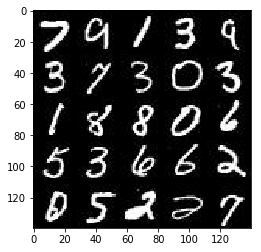

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

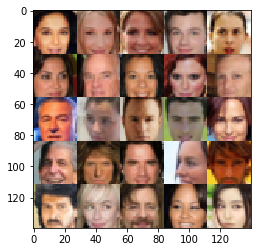

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_images")
    z_data = tf.placeholder(tf.float32, [None, z_dim], name="z_data")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_images, z_data, learning_rate 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 128
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.7)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = not is_train):

        x1 = tf.layers.dense(z, 4*4*256)

        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
   
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 7.4043... Generator Loss: 0.0010
Epoch 1/2... Discriminator Loss: 3.9056... Generator Loss: 0.0305
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 2.9470
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 2.0061
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 1.8684
Epoch 1/2... Discriminator Loss: 1.6164... Generator Loss: 1.9597
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 1.7022
Epoch 1/2... Discriminator Loss: 1.7748... Generator Loss: 1.7748
Epoch 1/2... Discriminator Loss: 1.6560... Generator Loss: 1.7217
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 1.5850


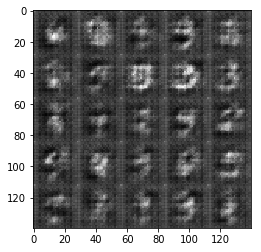

Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 1.4048
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 1.6508
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 1.3367
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 1.4909
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 1.3292
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 1.6785
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 1.7497
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 1.4186


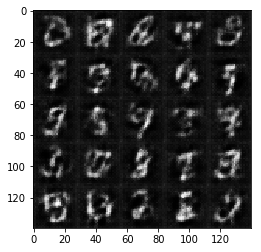

Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 1.4254
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 1.5017
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 1.5844
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 1.3485
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 1.7623
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 1.7652
Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 1.9608
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.5224


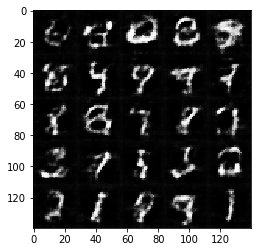

Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 1.5853
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 1.8241
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.8666... Generator Loss: 1.6483
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 1.5126
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 1.5180
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.9002


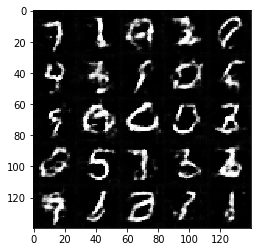

Epoch 1/2... Discriminator Loss: 1.2299... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.3610
Epoch 1/2... Discriminator Loss: 1.8361... Generator Loss: 0.2704
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.4860
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.6148
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 2.1802... Generator Loss: 0.1676


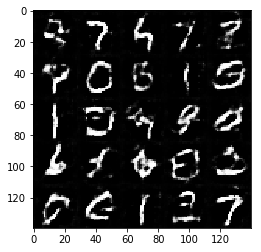

Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 1.5982... Generator Loss: 0.2968
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.5442... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.5964
Epoch 2/2... Discriminator Loss: 1.8513... Generator Loss: 0.2397
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.4352
Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.5744


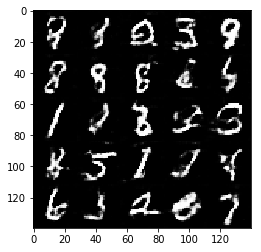

Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.5794
Epoch 2/2... Discriminator Loss: 1.8783... Generator Loss: 0.2201
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.3608
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.5001
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.6105
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.6832


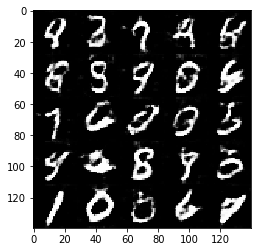

Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.4047
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.6421... Generator Loss: 2.2178
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.6664
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.5680... Generator Loss: 1.9712
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.2330


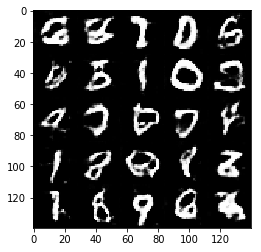

Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.6061
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 1.6082
Epoch 2/2... Discriminator Loss: 1.9603... Generator Loss: 2.4195
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 1.3696
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.8169


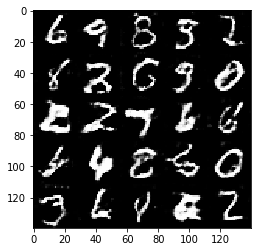

Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.5210
Epoch 2/2... Discriminator Loss: 1.9495... Generator Loss: 0.2169
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.5341


In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 8.2480
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 12.0368
Epoch 1/1... Discriminator Loss: 13.9114... Generator Loss: 23.4498
Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 3.6237
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 5.4781
Epoch 1/1... Discriminator Loss: 1.8293... Generator Loss: 7.7037
Epoch 1/1... Discriminator Loss: 0.0688... Generator Loss: 4.3638
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 5.4761
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 4.2118
Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 4.3045


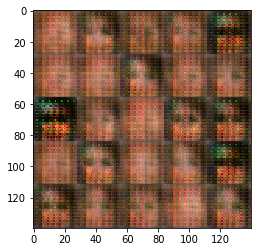

Epoch 1/1... Discriminator Loss: 7.5746... Generator Loss: 11.9181
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 4.4075
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.6330
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 4.9171
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 3.0301... Generator Loss: 5.6743
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5676


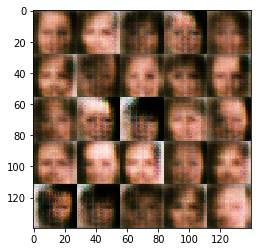

Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 1.9221
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 2.0456
Epoch 1/1... Discriminator Loss: 1.8313... Generator Loss: 0.3100
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.7515
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 1.9654
Epoch 1/1... Discriminator Loss: 0.0688... Generator Loss: 3.5424
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 1.1702


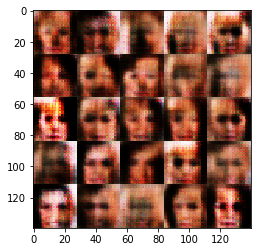

Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 2.0992
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 2.7108
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 2.1836
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 2.0596
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 2.9535
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.6415


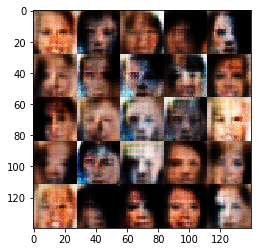

Epoch 1/1... Discriminator Loss: 2.5544... Generator Loss: 3.2292
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 3.2937
Epoch 1/1... Discriminator Loss: 0.3008... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 3.2329... Generator Loss: 0.0846
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0795


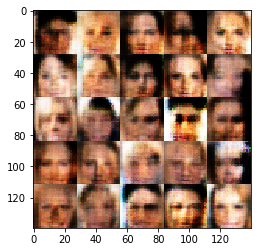

Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 3.2007... Generator Loss: 3.6055
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 2.6727
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 2.0091... Generator Loss: 0.2217
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.9626


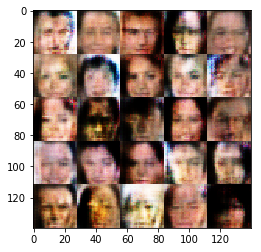

Epoch 1/1... Discriminator Loss: 1.7625... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 2.8791
Epoch 1/1... Discriminator Loss: 1.9520... Generator Loss: 0.1980
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.5309


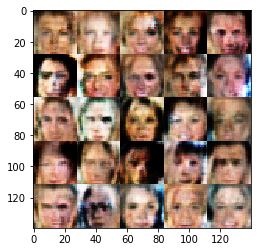

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 1.8024
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 0.2178


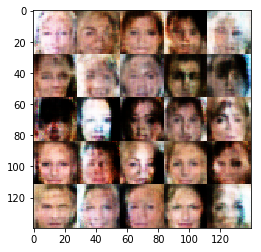

Epoch 1/1... Discriminator Loss: 2.0243... Generator Loss: 0.1955
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 2.6025
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.0232


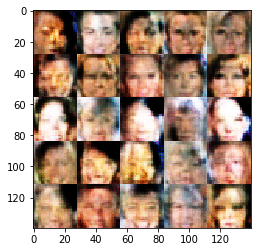

Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 5.5770
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 2.4155
Epoch 1/1... Discriminator Loss: 2.5707... Generator Loss: 0.1375
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6418


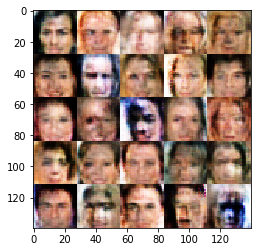

Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.3681
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.9319... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.8863
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 2.9031
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.4263


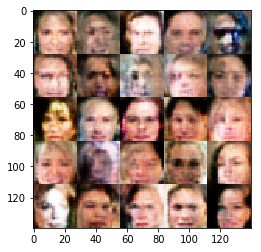

Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.8906
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 2.2720
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.8076... Generator Loss: 2.6836
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.3170


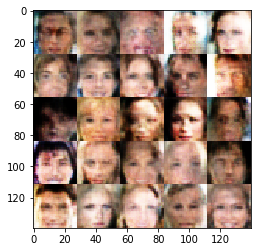

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.4340
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 2.2267
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.5251
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.0769
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 2.7475


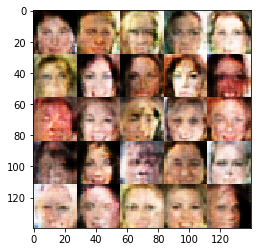

Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 1.6718
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 4.6627
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 1.4080


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.